# Algorithmic Trading (FOREX)

The foreign exchange market or forex is the most liquid market in the world. It is a global decentralized or over-the-counter (OTC) market for the trading of currencies. The currencies that are frequently traded provide ample opportunity
for training models and testing potential profit-oriented strategies. This is because more activity equals more liquidity
and stronger patterns both in the short and the long terms. This notebook looks at the currency pair, GBPUSD, for trading purposes. The goal of this notebook is to outline the algorithmic strategies (random forest classifier and the multilayer perceptron) that can be employed to generate buy and sell
signals.

Please note that the strategies presented in this notebook are exploratory in nature and therefore, may not be used
for investment.

In [ ]:
import itertools
import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import yfinance as yf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Downloading Data

The relevant FOREX data is downloaded from yahoo finance

In [ ]:
start_date = '2008-01-01'
ticker = 'GBPUSD=X'
ts = 'Close'

df_prices = yf.download(ticker, start=start_date, end=datetime.date.today().strftime('%Y-%m-%d'), progress=False)
df_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-01,1.985506,1.989812,1.978983,1.987716,1.987716,0
2008-01-02,1.987281,1.988981,1.978513,1.981807,1.981807,0
2008-01-03,1.981886,1.984009,1.970987,1.974100,1.974100,0
2008-01-04,1.974217,1.984599,1.968194,1.975816,1.975816,0
2008-01-07,1.971998,1.975582,1.966182,1.966994,1.966994,0


Setting up a DataFrame and adding all the information required for the analysis

In [ ]:
# Adding `return` to make it the targeted or test column
df_prices['return'] = np.log(df_prices[ts]).diff(1)  # Log return excl. interest
df_prices['return+1D'] = df_prices['return'].shift(-1)
# add class label: next day return is up or down, or neutral if within 1% of 1% around zero
df_prices['class'] = pd.cut(df_prices['return+1D'], [-np.inf, -5e-5, 5e-5, np.inf], labels=['down','neutral','up'])

# Adding technical analysis indicators
# Bollinger Bands(5)
df_prices['BBL'] = ta.bbands(close=df_prices[ts])['BBL_5']
df_prices['BBM'] = ta.bbands(close=df_prices[ts])['BBM_5']
df_prices['BBU'] = ta.bbands(close=df_prices[ts])['BBU_5']
# RSI(14)
df_prices['RSI'] = ta.rsi(close=df_prices[ts])
df_prices['RSI_slope'] = ta.slope(close=df_prices['RSI'])
# MACD
df_prices['MACD_signal'] = ta.macd(close=df_prices[ts])['MACDH_12_26_9']
df_prices['MACD_slope'] = ta.slope(close=df_prices['MACD_signal'])

# Keeping the Data Frame on which I will make predictions and test the algorithm
df = df_prices.dropna()

The '`return+1D`' is the column to be predicted and aginst which the model effectiveness will be measured. Also, the '`class`' column is used as a classification label for the Machine Learning Classifier

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,return,return+1D,class,BBL,BBM,BBU,RSI,RSI_slope,MACD_signal,MACD_slope
Date,,,,,,,,,,,,,,,,
2020-07-17,1.256013,1.257229,1.251345,1.255950,1.255950,0,-0.002505,0.000930,up,1.251891,1.257981,1.264072,53.669673,-2.440236,0.000807,-0.000335
2020-07-20,1.257229,1.265935,1.251909,1.257118,1.257118,0,0.000930,0.007179,up,1.253897,1.256855,1.259813,54.456782,0.787108,0.000607,-0.000200
2020-07-21,1.266464,1.275136,1.265278,1.266175,1.266175,0,0.007179,0.005434,up,1.250771,1.259055,1.267338,60.088385,5.631604,0.001005,0.000397
2020-07-22,1.273447,1.274080,1.264574,1.273075,1.273075,0,0.005434,-0.000064,down,1.247844,1.262284,1.276724,63.747089,3.658704,0.001615,0.000611
2020-07-23,1.273091,1.275982,1.267427,1.272993,1.272993,0,-0.000064,0.000064,up,1.248495,1.265062,1.281630,63.673608,-0.073481,0.001879,0.000264


Adding an additional ARMA column to get one additional input for the algorithm. The idea is to set up a rolling window on which the ARMA model will be fitted

In [ ]:
# ARMA prediction
def arima_forecast(series):
    '''Fit an ARIMA model using the input series and predict the immediate
    next value. Prediction will be 0 if there is any error
    '''
    if sm.tsa.adfuller(series, 1)[1] >= 0.05:
        print('The returns process isnt stationary')
        return 0
    # Fitting ARMA on a rolling window
    # Optimizing just with AIC criterion
    aic_value = np.inf
    best_model = None
    for p,q in itertools.product([1,2],[1,2]):
        try:
            arima_model = sm.tsa.ARIMA(series, order=(p,0,q)).fit(disp=0)
            if arima_model.aic < aic_value:
                best_model = arima_model
        except:
            pass

    try:
        forecast = best_model.forecast(steps=1)[0][0]
        return forecast
    except:
        return 0

rolling_window = 300
test_days = 1000

# forecast by ARMA on a window, rolling backward in the following loop
forecasts = []
for i in range(1, test_days+1):
    series = df['return'][-rolling_window-i:-i]
    forecasts.append(arima_forecast(series))

paddings = [0] * (len(df)-len(forecasts))
df['ARMA forecast'] = paddings + forecasts[::-1]

The ARMA model will be ran on the last 1000 rows

In [ ]:
df_algo = df.iloc[-test_days:, :]
df_algo.head()

,Open,High,Low,Close,Adj Close,Volume,return,return+1D,class,BBL,BBM,BBU,RSI,RSI_slope,MACD_signal,MACD_slope,ARMA forecast
Date,,,,,,,,,,,,,,,,,
2016-09-20,1.303951,1.306506,1.295102,1.304461,1.304461,0,0.002176,-0.004555,down,1.292211,1.315345,1.338479,42.160807,1.515026,-0.002216,-0.000881,-0.002904
2016-09-21,1.298533,1.300728,1.295001,1.298533,1.298533,0,-0.004555,0.003903,up,1.284449,1.311164,1.337880,39.880390,-2.280417,-0.003042,-0.000826,0.000573
2016-09-22,1.303781,1.311992,1.303271,1.303611,1.303611,0,0.003903,0.003918,up,1.285782,1.306599,1.327417,42.723665,2.843276,-0.003081,-0.000039,-0.000253
2016-09-23,1.308404,1.309072,1.291656,1.308729,1.308729,0,0.003918,-0.008341,down,1.295881,1.303392,1.310903,45.506530,2.782865,-0.002614,0.000466,0.000620
2016-09-26,1.297858,1.299039,1.291823,1.297858,1.297858,0,-0.008341,-0.000701,down,1.293635,1.302639,1.311642,40.975939,-4.530591,-0.002871,-0.000256,0.000258


The algorithmic model will focus on the following:

- RSI_slope difference applied
- MACD_slope difference applied
- ARMA prediction

In [ ]:
df_algo['RSI_slope_chg'] = df_algo['RSI_slope'].diff(1)
df_algo['MACD_slope_chg'] = df_algo['MACD_slope'].diff(1)
df_algo = df_algo[[ts,'return+1D','class','RSI_slope_chg','MACD_slope_chg','ARMA forecast']]
df_algo.dropna(inplace=True)
df_algo.head()

,Close,return+1D,class,RSI_slope_chg,MACD_slope_chg,ARMA forecast
Date,,,,,,
2016-09-21,1.298533,0.003903,up,-3.795443,0.000055,0.000573
2016-09-22,1.303611,0.003918,up,5.123693,0.000787,-0.000253
2016-09-23,1.308729,-0.008341,down,-0.060411,0.000505,0.000620
2016-09-26,1.297858,-0.000701,down,-7.313456,-0.000722,0.000258
2016-09-27,1.296950,0.003300,up,4.168340,0.000203,-0.001428


As RSI_slope_chg and MACD_slope_chg have different scales, the Standard Scaler Transformation is applied

In [ ]:
rsi_scaler = StandardScaler()
macd_scaler = StandardScaler()
df_algo['RSI_slope_chg'] = rsi_scaler.fit_transform(df_algo[['RSI_slope_chg']])
df_algo['MACD_slope_chg'] = macd_scaler.fit_transform(df_algo[['MACD_slope_chg']])
df_algo.head()

,Close,return+1D,class,RSI_slope_chg,MACD_slope_chg,ARMA forecast
Date,,,,,,
2016-09-21,1.298533,0.003903,up,-0.627364,0.099328,0.000573
2016-09-22,1.303611,0.003918,up,0.847534,1.451543,-0.000253
2016-09-23,1.308729,-0.008341,down,-0.009727,0.930413,0.000620
2016-09-26,1.297858,-0.000701,down,-1.209114,-1.336216,0.000258
2016-09-27,1.296950,0.003300,up,0.689553,0.372694,-0.001428


Trying different options in order to see which fits best

In [ ]:
# Trade recommendation according to ARMA prediction
df_algo['ARMA recomm'] = pd.cut(df_algo['ARMA forecast'], [-np.inf, -np.spacing(np.float16(0)), np.spacing(np.float16(0)), np.inf], labels=[-1,0,1]).astype(int)
df_algo.tail()

,Close,return+1D,class,RSI_slope_chg,MACD_slope_chg,ARMA forecast,ARMA recomm
Date,,,,,,,
2020-07-17,1.255950,0.000930,up,-0.621965,-0.461650,1.475012e-04,1
2020-07-20,1.257118,0.007179,up,0.533947,0.247917,-3.241458e-04,-1
2020-07-21,1.266175,0.005434,up,0.801365,1.101170,-6.959332e-07,-1
2020-07-22,1.273075,-0.000064,down,-0.325982,0.392384,1.572818e-03,1
2020-07-23,1.272993,0.000064,up,-0.616903,-0.643495,1.395010e-03,1


In [ ]:
df_algo.iloc[:, 3:]

,RSI_slope_chg,MACD_slope_chg,ARMA forecast,ARMA recomm
Date,,,,
2016-09-21,-0.627364,0.099328,5.725619e-04,1
2016-09-22,0.847534,1.451543,-2.529360e-04,-1
2016-09-23,-0.009727,0.930413,6.203578e-04,1
2016-09-26,-1.209114,-1.336216,2.582148e-04,1
2016-09-27,0.689553,0.372694,-1.428127e-03,-1
...,...,...,...,...
2020-07-17,-0.621965,-0.461650,1.475012e-04,1
2020-07-20,0.533947,0.247917,-3.241458e-04,-1
2020-07-21,0.801365,1.101170,-6.959332e-07,-1


## The random forest classifier

In [ ]:
# Train a machine learning model using random forest classifier with technical indicators as input
y = df_algo['class']
X = df_algo[['RSI_slope_chg', 'MACD_slope_chg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
t_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
t_classifier.fit(X_train, y_train)
y_pred = t_classifier.predict(X)

def pos_classifier(x):
    return -1 if x=='down' else 1 if x=='up' else 0

df_algo['Tech recomm'] = [pos_classifier(i) for i in y_pred]
df_algo.tail()

,Close,return+1D,class,RSI_slope_chg,MACD_slope_chg,ARMA forecast,ARMA recomm,Tech recomm
Date,,,,,,,,
2020-07-17,1.255950,0.000930,up,-0.621965,-0.461650,1.475012e-04,1,1
2020-07-20,1.257118,0.007179,up,0.533947,0.247917,-3.241458e-04,-1,1
2020-07-21,1.266175,0.005434,up,0.801365,1.101170,-6.959332e-07,-1,1
2020-07-22,1.273075,-0.000064,down,-0.325982,0.392384,1.572818e-03,1,-1
2020-07-23,1.272993,0.000064,up,-0.616903,-0.643495,1.395010e-03,1,1


In [ ]:
# Train a machine learning model using random forest classifier with technical indicators and ARMA forecast as input
y = df_algo['class']
X = df_algo[['RSI_slope_chg', 'MACD_slope_chg', 'ARMA forecast']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
at_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
at_classifier.fit(X_train, y_train)
y_pred = at_classifier.predict(X)

df_algo['ARMA+Tech recomm'] = [pos_classifier(i) for i in y_pred]
df_algo.tail()

,Close,return+1D,class,RSI_slope_chg,MACD_slope_chg,ARMA forecast,ARMA recomm,Tech recomm,ARMA+Tech recomm
Date,,,,,,,,,
2020-07-17,1.255950,0.000930,up,-0.621965,-0.461650,1.475012e-04,1,1,1
2020-07-20,1.257118,0.007179,up,0.533947,0.247917,-3.241458e-04,-1,1,1
2020-07-21,1.266175,0.005434,up,0.801365,1.101170,-6.959332e-07,-1,1,1
2020-07-22,1.273075,-0.000064,down,-0.325982,0.392384,1.572818e-03,1,-1,-1
2020-07-23,1.272993,0.000064,up,-0.616903,-0.643495,1.395010e-03,1,1,1


## The multilayer perceptron

In [ ]:
# Train an MLP to predict return using walk-forward technique
def lags_concat(series, lag=1, na=0):
    '''convert a series into a dataframe of consecutive lags for supervised learning
    Args:
        series: a single time series, expecting pandas.Series or single column pandas.DataFrame
        lag: postive integer of number of lags as predictor
        na: can be a number to fill the NaN values in output (missing histories), or 'drop'
            to remove those, or None to keep it as NaN
    Returns:
        A DataFrame of lag columns which each is the lagged input series
    '''
    df = pd.DataFrame(series)
    columns = [df.shift(i) for i in range(1, lag+1)]
    df = pd.concat(columns, axis=1)
    if na == 'drop':
        df = df.dropna()
    elif na is not None:
        df.fillna(na)
    return df

def fit_mlp(X, y, batch_size, n_epoch):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, input_shape=(X.shape[1],), activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(y.shape[1], activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the model
    model.fit(X, y, epochs=n_epoch, batch_size=batch_size, validation_split=0.2, verbose=0)
    return model

In [ ]:
# walk-forward prediction on return directly using MLP regressor:
# I first format data for MLP use, then fit a model for the weights

# format data for MLP use
mlp_df = lags_concat(df_prices['return'], 100, na='drop')
mlp_labels = pd.cut(df_prices['return'], [-np.inf, -5e-5, 5e-5, np.inf], labels=['down','neutral','up'])
mlp_labels = pd.get_dummies(mlp_labels)  # convert label into one-hot encoding

# clip data for last 1300 days, train with first 1000
mlp_df = mlp_df.iloc[-1300:]
mlp_labels = mlp_labels.iloc[-1300:]
mlp_df_train = mlp_df.iloc[:1000]
mlp_labels_train = mlp_labels.iloc[:1000]
mlp_model = fit_mlp(mlp_df_train.values, mlp_labels_train.values, 8, 5000)

# run prediction
yhat = mlp_model.predict(mlp_df.values)

# Save the recommendation
df_algo['MLP recomm'] = pd.Series(np.argmax(yhat, axis=1) - 1, index=mlp_df.index).loc[df_algo.index]

Reviewing Results

In [ ]:
# Take only the recommendation column and determine the trading action
df_results = df_algo[['return+1D','ARMA recomm','Tech recomm','ARMA+Tech recomm','MLP recomm']].infer_objects()
for key in ['ARMA','Tech','ARMA+Tech','MLP']:
    df_results[key+' action'] = df_results[key+' recomm'].mask(df_results[key+' recomm'].eq(df_results[key+' recomm'].shift(1)), 0)
    # start with a buy
    for i in range(len(df_results)):
        if df_results[key+' action'][i] == 1:
            break
        elif df_results[key+' action'][i] == -1:
            df_results[key+' action'][i] = 0
    # end with a sell to close out position
    for i in range(len(df_results)-1, -1, -1):
        if df_results[key+' action'][i] == -1:
            break
        elif df_results[key+' action'][i] == 1:
            df_results[key+' action'][i] = 0

df_results.head()

,return+1D,ARMA recomm,Tech recomm,ARMA+Tech recomm,MLP recomm,ARMA action,Tech action,ARMA+Tech action,MLP action
Date,,,,,,,,,
2016-09-21,0.003903,1,-1,-1,-1,1,0,0,0
2016-09-22,0.003918,-1,1,1,1,-1,1,1,1
2016-09-23,-0.008341,1,1,1,1,1,0,0,0
2016-09-26,-0.000701,1,-1,-1,-1,0,-1,-1,-1
2016-09-27,0.003300,-1,1,1,-1,-1,1,1,0


In [ ]:
df_results['long only return'] = df_results['return+1D'].cumsum()
for key in ['ARMA','Tech','ARMA+Tech','MLP']:
    df_results[key+' return'] = (df_results['return+1D']*df_results[key+' action']).cumsum()
df_results.head()

,return+1D,ARMA recomm,Tech recomm,ARMA+Tech recomm,MLP recomm,ARMA action,Tech action,ARMA+Tech action,MLP action,long only return,ARMA return,Tech return,ARMA+Tech return,MLP return
Date,,,,,,,,,,,,,,
2016-09-21,0.003903,1,-1,-1,-1,1,0,0,0,0.003903,0.003903,0.000000,0.000000,0.000000
2016-09-22,0.003918,-1,1,1,1,-1,1,1,1,0.007822,-0.000015,0.003918,0.003918,0.003918
2016-09-23,-0.008341,1,1,1,1,1,0,0,0,-0.000519,-0.008356,0.003918,0.003918,0.003918
2016-09-26,-0.000701,1,-1,-1,-1,0,-1,-1,-1,-0.001220,-0.008356,0.004619,0.004619,0.004619
2016-09-27,0.003300,-1,1,1,-1,-1,1,1,0,0.002080,-0.011656,0.007919,0.007919,0.004619


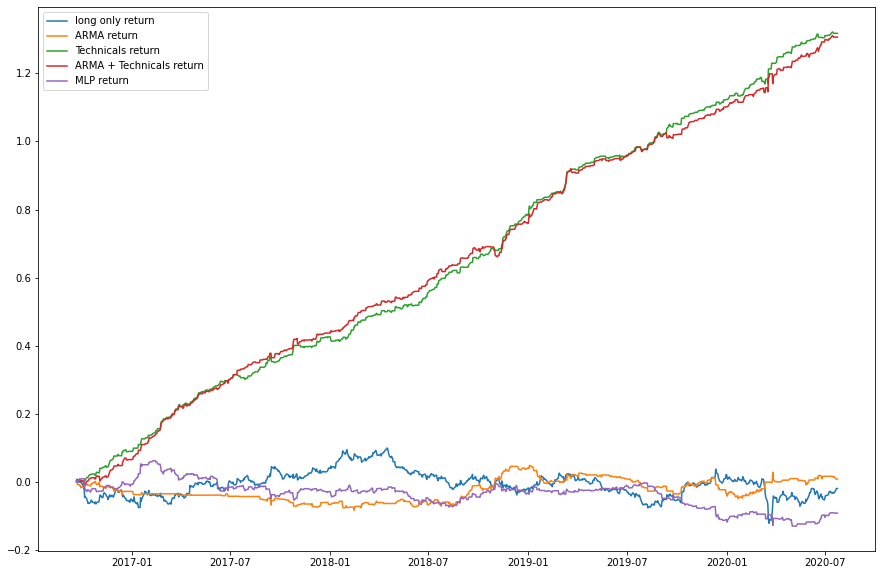

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df_results[['long only return','ARMA return','Tech return','ARMA+Tech return','MLP return']])
plt.legend(['long only return','ARMA return','Technicals return','ARMA + Technicals return','MLP return'])
plt.show()